# Algorithme par gradient de Politique

Dans ce TP, l'objectif est d'implémenter l'algorithme REINFORCE basé sur le gradient de la politique pour trouver une politique optimale pour l'environnement [CartPole](https://gymnasium.farama.org/environments/classic_control/cart_pole/).

> Vous devez  <span style="color:red"> commenter votre code ! </span> 
> 
> Vous devez aussi répondre à des questions (dans les cellules <span style="color:blue">Votre réponse: </span> )


> Le code doit être fonctionnel avec l'environnement virtuel du TP. Si d'autres packages que ceux présents dans l'environnement virtuel créé au départ sont nécessaires, vous devez ajouter à votre dépôt un fichier `environnement.yaml` qui est un export de votre environnement virtuel. Ce fichier est obtenu avec la commande suivante:  ```conda env export > environnement.yaml```

In [10]:
import gymnasium as gym
import random
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import utils
%matplotlib inline
%load_ext autoreload

def init_seed(seedval):
    torch.manual_seed(seedval)
    np.random.seed(seedval)
    random.seed(seedval)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# 1 Définition de la Politique

L'algorithme REINFORCE utilise des politiques stochastiques, ainsi que la log probabilité des actions prises dans chaque état. Pour cela, les [distributions PyTorch](https://pytorch.org/docs/stable/distributions.html) sont à utiliser.



> <span style="color:green">- Qu'est-ce qui sera en entrée de la politique ? En sortie ?  </span>

> <span style="color:blue">Votre réponse: </span>

En entrée de la politique : l'état de l'environnement, représenté par un vecteur de 4 valeurs continues dans le cas de CartPole (position, vitesse, angle et vitesse angulaire de la tige).  
En sortie de la politique : une distribution de probabilité sur les actions possibles (à gauche ou à droite), permettant de sélectionner une action de manière stochastique.

Compléter ci-dessous la politique.


In [11]:
class Politique(nn.Module):
    def __init__(self, dim_entree: int, dim_sortie: int, dim_cachee: int):
        super(Politique, self).__init__()

        self.fc1 = nn.Linear(dim_entree, dim_cachee)
        self.fc2 = nn.Linear(dim_cachee, dim_sortie)

    def forward(self, etat: np.ndarray) -> torch.Tensor:
        x = F.relu(self.fc1(etat))
        logits = self.fc2(x)
        return logits

    def action(self, etat: np.ndarray) -> tuple[int, torch.Tensor]:
        """
        Renvoie l'action à exécuter dans l'état et la log-proba de cette action
        """
        if isinstance(etat, np.ndarray):
            etat = torch.tensor(etat, dtype=torch.float).unsqueeze(0) 

        logits = self.forward(etat)
        distribution = Categorical(logits=logits)  # Crée une distribution de probabilités à partir des logits
        action = distribution.sample()  # Échantillonne une action
        log_prob = distribution.log_prob(action)  # Calcule la log-probabilité de cette action

        return action.item(), log_prob


# 2 Algorithme REINFORCE

> <span style="color:green">- Redonner ci-dessous les différentes étapes de l'algorithme REINFORCE.  </span>

> <span style="color:blue">Votre réponse: </span>  
Échantillonnage d'une trajectoire : exécuter la politique actuelle pour générer une trajectoire (séquence d'états, actions et récompenses) jusqu'à la fin de l'épisode.
Calcul des retours : pour chaque action de la trajectoire, calculer le retour (somme des récompenses futures cumulées).  
Calcul des gradients : pour chaque action dans la trajectoire, calculer le gradient du logarithme de la probabilité de l'action multiplié par le retour.  
Mise à jour des paramètres : mettre à jour les paramètres de la politique en suivant le gradient de la politique, en moyenne sur l'épisode.  

Compléter la méthode *trajectoire* qui se charge de collecter UNE trajectoire avec la politique *politique*, et de renvoyer les données suivantes: 
- liste des récompenses obtenues à chaque pas de la trajectoire, 
- liste des log proba des actions prises à chaque pas de la trajectoire.

In [12]:

def trajectoire(env,politique, max_t:int =500)->  tuple[list,list]:
    """
        max_t: nombre max de pas de la trajectoire
    """
    etat, _ = env.reset(seed=random.randint(0,5000))
    #TO DO
    recompenses = []
    log_probs = []

    for t in range(max_t):
        action, log_prob = politique.action(etat)        # Choix d'une action et récupération de sa log-probabilité
        etat, recompense, termine, _, _ = env.step(action) # Exécution de l'action dans l'environnement
        
        recompenses.append(recompense)
        log_probs.append(log_prob)

        if termine:
            break

    return recompenses, log_probs



Collecter ci-dessous 10 trajectoires avec une politique, et afficher la somme des récompenses de chaque trajectoire.

In [13]:
env = gym.make("CartPole-v1")
init_seed(5)
#TO DO
dim_entree = env.observation_space.shape[0]
dim_sortie = env.action_space.n
dim_cachee = 128

# Création de la politique avec les dimensions d'entrée et de sortie appropriées
politique = Politique(dim_entree, dim_sortie, dim_cachee)

# Liste pour stocker les récompenses totales de chaque trajectoire
somme_recompenses_trajectoires = []

# Collecte de 10 trajectoires
for i in range(10):
    recompenses, _ = trajectoire(env, politique, max_t=500)
    somme_recompenses = sum(recompenses)
    somme_recompenses_trajectoires.append(somme_recompenses) # Stockage de la somme

# Affichage des sommes des récompenses de chaque trajectoire
for i, somme in enumerate(somme_recompenses_trajectoires, 1):
    print(f"Trajectoire {i}: Somme des récompenses = {somme}")


Trajectoire 1: Somme des récompenses = 25.0
Trajectoire 2: Somme des récompenses = 24.0
Trajectoire 3: Somme des récompenses = 29.0
Trajectoire 4: Somme des récompenses = 19.0
Trajectoire 5: Somme des récompenses = 38.0
Trajectoire 6: Somme des récompenses = 13.0
Trajectoire 7: Somme des récompenses = 40.0
Trajectoire 8: Somme des récompenses = 15.0
Trajectoire 9: Somme des récompenses = 39.0
Trajectoire 10: Somme des récompenses = 14.0


> <span style="color:green">- Expliquer pourquoi l'algorithme REINFORCE a une variance élevée mais un biais faible.  </span>


> <span style="color:blue">Votre réponse: </span>  
L'algorithme REINFORCE a une variance élevée car les trajectoires d'épisodes sont très variables, entraînant des fluctuations importantes dans les estimations des gradients. Il a un biais faible parce qu'il converge vers une politique optimale en maximisant les récompenses cumulées, ce qui garantit que les estimations des gradients, bien que variables, restent en moyenne précises.

# 3 REINFORCE avec m=1 (1 trajectoire par rollout)

La méthode *loss_reinforce* ci-dessous calcule à partir des informations sur une trajectoire $\tau = (s_0,a_0,r_0,s_1, ...,s_{H+1})$ :
$$\sum_{t=0}^H log \pi_\theta(a_t | s_t) R(\tau)$$
avec le retour cumulé total sur la trajectoire:
$$R(\tau) = \sum_{t=0}^H \gamma^t r_t$$

Compléter la méthode *reinforce* pour implémenter l'algorithme REINFORCE avec **une seule trajectoire par rollout**:
- la méthode *reinforce* renvoie la somme des récompenses obtenue à chaque itération (une trajectoire par itération)
- la méthode *reinforce* doit afficher toutes les *n* itérations, la somme des récompenses obtenue à l'itération (ou une moyenne)

In [14]:
def loss_reinforce(log_probs:list, retour_cumule:float):
    """
        log_probs: liste des log proba des actions prises à chaque pas d'une trajectoire 
        retour_cumule : somme pondérée des recompenses obtenue sur une trajectoire
        renvoi: loss = - sum_t logproba(a_t) * retour_cumule
    """
    loss = []
    for log_prob in log_probs: 
        loss.append(-log_prob * retour_cumule) 
    return torch.cat(loss).sum()

def reinforce(env,politique, nb_episodes=2000, gamma=0.99, max_t=500) -> list:

    optimizer = optim.Adam(politique.parameters(), lr=1e-2)
    #TO COMPLETE
    somme_recompenses = []  # Liste pour stocker les sommes des récompenses de chaque épisode

    for episode in range(nb_episodes):
        # Collecte d'une trajectoire
        recompenses, log_probs = trajectoire(env, politique, max_t=max_t)

        # Calcul du retour cumulé
        retour_cumule = sum(gamma ** t * r for t, r in enumerate(recompenses))

        loss = loss_reinforce(log_probs, retour_cumule)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Stocker la somme des récompenses pour cet épisode
        somme_recompenses.append(sum(recompenses))

        # Afficher la somme des récompenses tous les n épisodes
        if (episode + 1) % 100 == 0:
            print(f"Épisode {episode + 1}: Somme des récompenses = {somme_recompenses[-1]}")

    return somme_recompenses

        


> <span style="color:green">-  Tester l'algorithme en tracant la somme des récompenses obtenues à chaque itération de l'algorithme, puis en évaluant la politique obtenue.  Analysez vos résultats.  </span>


Épisode 100: Somme des récompenses = 73.0
Épisode 200: Somme des récompenses = 43.0
Épisode 300: Somme des récompenses = 200.0
Épisode 400: Somme des récompenses = 45.0
Épisode 500: Somme des récompenses = 48.0
Épisode 600: Somme des récompenses = 121.0
Épisode 700: Somme des récompenses = 80.0
Épisode 800: Somme des récompenses = 30.0
Épisode 900: Somme des récompenses = 55.0
Épisode 1000: Somme des récompenses = 43.0
Épisode 1100: Somme des récompenses = 29.0
Épisode 1200: Somme des récompenses = 34.0
Épisode 1300: Somme des récompenses = 52.0
Épisode 1400: Somme des récompenses = 27.0
Épisode 1500: Somme des récompenses = 44.0
Épisode 1600: Somme des récompenses = 94.0
Épisode 1700: Somme des récompenses = 56.0
Épisode 1800: Somme des récompenses = 117.0
Épisode 1900: Somme des récompenses = 106.0
Épisode 2000: Somme des récompenses = 70.0
Épisode 2100: Somme des récompenses = 89.0


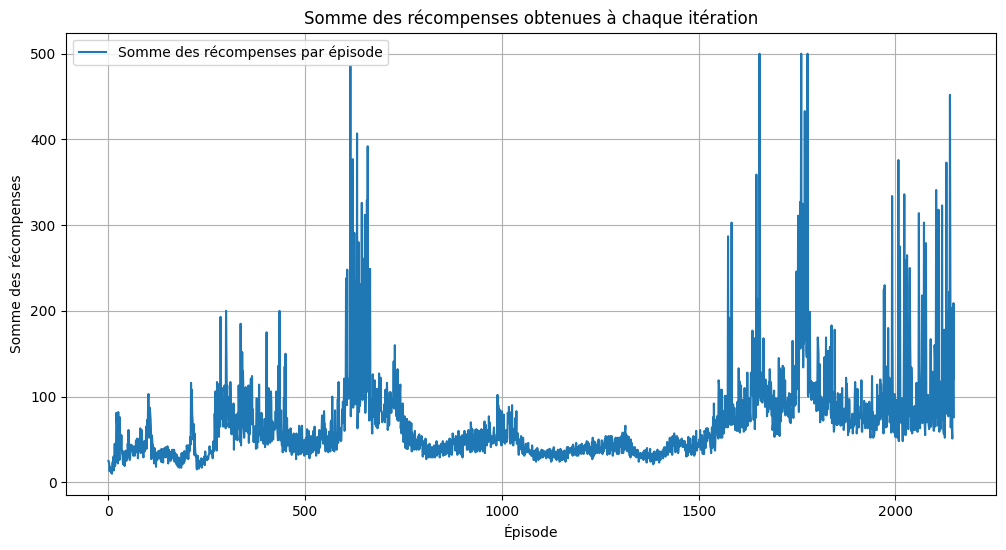

Moyenne des récompenses sur 10 épisodes d'évaluation : 128.0


In [31]:
import matplotlib.pyplot as plt

# Initialiser l'environnement et la politique
env = gym.make("CartPole-v1")
init_seed(5)
dim_entree = env.observation_space.shape[0]
dim_sortie = env.action_space.n
dim_cachee = 128
politique = Politique(dim_entree, dim_sortie, dim_cachee)

# Exécuter l'algorithme REINFORCE
somme_recompenses = reinforce(env, politique, nb_episodes=2150, gamma=0.99, max_t=500)
#après environ 2150 épisodes les résultats sont en dessous de 20, pour avoir une bonne éval on arrête avant

# Tracer la somme des récompenses obtenues à chaque itération
plt.figure(figsize=(12, 6))
plt.plot(somme_recompenses, label='Somme des récompenses par épisode')
plt.xlabel('Épisode')
plt.ylabel('Somme des récompenses')
plt.title('Somme des récompenses obtenues à chaque itération')
plt.legend()
plt.grid()
plt.show()

# Évaluation de la politique
def evaluer_politique(env, politique, nb_episodes=10):
    recompenses_totales = []
    
    for _ in range(nb_episodes):
        recompenses, _ = trajectoire(env, politique, max_t=500)
        recompenses_totales.append(sum(recompenses))
    
    return np.mean(recompenses_totales)

recompenses_eval = evaluer_politique(env, politique)

# Afficher les résultats d'évaluation
print(f"Moyenne des récompenses sur 10 épisodes d'évaluation : {recompenses_eval}")




On observe des variations importantes dans la somme des récompenses d'un épisode à l'autre. Cette variance élevée est due au fait que REINFORCE utilise une seule trajectoire pour mettre à jour la politique à chaque étape.  
Sur la fin de l'épisode les récompenses moyennes augmentes ce qui montre qu'il a quand même appris.  
l'algorithme REINFORCE devrait conduire à une politique qui maximise progressivement les récompenses, avec une courbe de récompenses qui augmente et se stabilise vers une valeur proche de 500 (le maximum pour CartPole).  
Cepdant ce n'est pas le cas L’utilisation d'une seule trajectoire par "rollout" (qui introduit beaucoup de variance), la convergence est plus lente et irrégulière. 

# 4 REINFORCE avec reward-to-go

Une action prise à l'instant $t$ impacte uniquement les récompenses obtenues à partir de $t$, et pas les récompenses passées. 

Pour améliorer l'algorithme précédent, on peut calculer la $loss$ en considérant à chaque action la somme pondérée des récompenses obtenues sur la trajectoire à partir de cette action (retour cumulé à chaque pas)

La méthode *loss_reinforce2* calcule à partir des informations sur une trajectoire  $\tau = (s_0,a_0,r_0,s_1, ...,s_{H+1})$ :
$$\sum_t log \pi_\theta(a_t | s_t) R_t(\tau)$$
avec le retour cumulé au pas $t$:
$$R_t(\tau) = \sum_{k=t}^H \gamma^{k-t} r_k$$


Compléter la méthode *retours_cumules* ci-dessous.


In [16]:
def loss_reinforce2(log_probs:list, retours_cumules:list):
    """
        log_probs: liste des log proba des actions prises à chaque pas d'une trajectoire 
        retours_cumules : liste des retours cumulés à chaque pas de la trajectoire
        renvoi: loss = - sum_t logproba(a_t) * retour_cumule_t
    """
    loss = []
    for log_prob,r_cumul in zip(log_probs,retours_cumules): 
        loss.append(-log_prob * r_cumul) 
    return torch.cat(loss).sum()


def retours_cumules(recompenses : list, gamma: float =0.99):
    """
       recompenses: liste des récompenses reçues à chaque pas de la trajectoire
       renvoi: retour cumulé à chaque pas de la trajectoire
    """
    #TODO
    retours = []
    H = len(recompenses)  # Nombre total de pas dans la trajectoire
    cumul = 0.0

    # On parcourt les récompenses à l'envers pour calculer les retours cumulés
    for t in reversed(range(H)):
        cumul = recompenses[t] + gamma * cumul  # Calcule le retour cumulé
        retours.insert(0, cumul)                # Insère le retour à l'indice 0 pour garder l'ordre

    return retours






Compléter la méthode *reinforce2* our implémenter l'algorithme REINFORCE avec **une seule trajectoire par rollout** et le retour cumulé à partir de chaque action dans la $loss$:
- la méthode *reinforce2* renvoie la somme des récompenses obtenue à chaque itération (une trajectoire par itération)
- la méthode *reinforce* doit afficher toutes les *n* itérations, la somme des récompenses obtenue à l'itération (ou une moyenne)

In [17]:
def reinforce2(env,politique, nb_episodes=2000, gamma=0.99,  max_t=500) -> list:
    optimizer = optim.Adam(politique.parameters(), lr=1e-2)
     #TO COMPLETE

    somme_recompenses = []  # Liste pour stocker les sommes des récompenses de chaque épisode

    for episode in range(nb_episodes):
        recompenses, log_probs = trajectoire(env, politique, max_t=max_t)

        retours_cumules_list = retours_cumules(recompenses, gamma)

        loss = loss_reinforce2(log_probs, retours_cumules_list)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Stocker la somme des récompenses pour cet épisode
        somme_recompenses.append(sum(recompenses))

        # Afficher la somme des récompenses tous les n épisodes
        if (episode + 1) % 100 == 0:
            print(f"Épisode {episode + 1}: Somme des récompenses = {somme_recompenses[-1]}")

    return somme_recompenses


> <span style="color:green">-  Tester l'algorithme en tracant la somme des récompenses obtenues à chaque itération de l'algorithme, puis en évaluant la politique obtenue. Analysez vos résultats (comparez au résultat obtenu précédemment, expliquez ce que vous espériez obtenir, ...).  </span>


Épisode 100: Somme des récompenses = 80.0
Épisode 200: Somme des récompenses = 286.0
Épisode 300: Somme des récompenses = 113.0
Épisode 400: Somme des récompenses = 120.0
Épisode 500: Somme des récompenses = 53.0
Épisode 600: Somme des récompenses = 77.0
Épisode 700: Somme des récompenses = 107.0
Épisode 800: Somme des récompenses = 112.0
Épisode 900: Somme des récompenses = 195.0
Épisode 1000: Somme des récompenses = 112.0
Épisode 1100: Somme des récompenses = 109.0
Épisode 1200: Somme des récompenses = 86.0
Épisode 1300: Somme des récompenses = 91.0
Épisode 1400: Somme des récompenses = 235.0
Épisode 1500: Somme des récompenses = 147.0
Épisode 1600: Somme des récompenses = 180.0
Épisode 1700: Somme des récompenses = 500.0
Épisode 1800: Somme des récompenses = 134.0
Épisode 1900: Somme des récompenses = 156.0
Épisode 2000: Somme des récompenses = 222.0
Épisode 2100: Somme des récompenses = 500.0


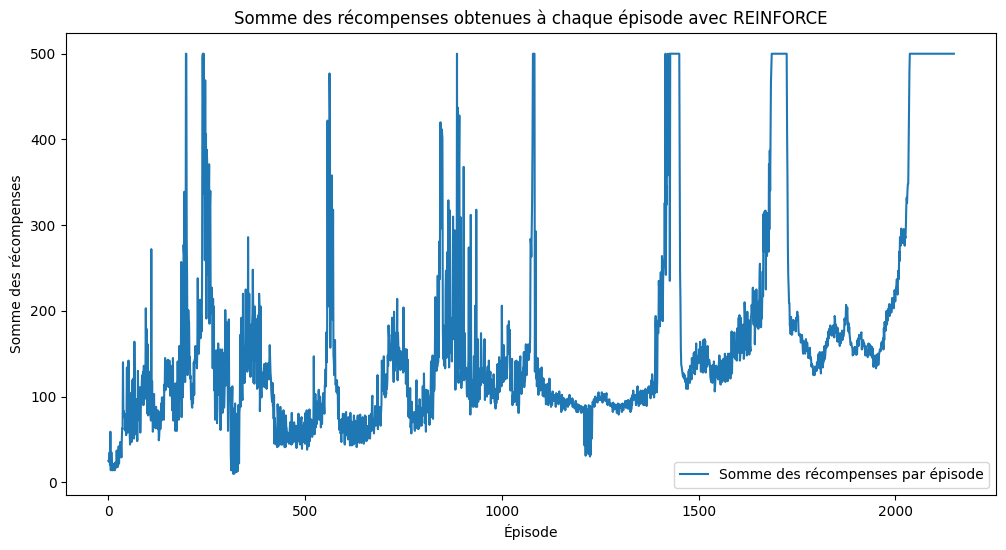

Moyenne des récompenses sur 10 épisodes d'évaluation : 500.0


In [29]:
import matplotlib.pyplot as plt

# Initialisation de l'environnement
env = gym.make("CartPole-v1")
init_seed(5)
dim_entree = env.observation_space.shape[0]
dim_sortie = env.action_space.n
dim_cachee = 128
politique = Politique(dim_entree, dim_sortie, dim_cachee)

# Appel à la fonction reinforce2
somme_recompenses = reinforce2(env, politique, nb_episodes=2150, gamma=0.99, max_t=500) 
#après environ 2150 épisodes les résultats sont en dessous de 20, pour avoir une bonne éval on arrête avant

# Tracer la somme des récompenses obtenues à chaque épisode
plt.figure(figsize=(12, 6))
plt.plot(somme_recompenses, label='Somme des récompenses par épisode')
plt.xlabel('Épisode')
plt.ylabel('Somme des récompenses')
plt.title('Somme des récompenses obtenues à chaque épisode avec REINFORCE')
plt.legend()
plt.show()

# Évaluation de la politique
def evaluer_politique(env, politique, nb_episodes=10):
    recompenses_totales = []
    
    for _ in range(nb_episodes):
        recompenses, _ = trajectoire(env, politique, max_t=500)
        recompenses_totales.append(sum(recompenses))
    
    return np.mean(recompenses_totales)

recompenses_eval = evaluer_politique(env, politique)

# Afficher les résultats d'évaluation
print(f"Moyenne des récompenses sur 10 épisodes d'évaluation : {recompenses_eval}")



L’approche "reward-to-go" apporte une amélioration en termes de stabilité d'apprentissage, avec des pics plus réguliers et une réduction des fluctuations en fin d'entraînement, ayant même atteind le max de récompenses pendant une centaines d'épisode (après environ 2150 épisode on retombe à une moyenne de 20 pendant des miliers d'épisode).

Dans le premier graphique, il a fallu plus de temps et de nombreux épisodes avant que des récompenses élevées ne soient obtenues régulièrement. Ici, l’algorithme atteind des récompenses élevées un peu plus tôt.

L’objectif de l’approche "reward-to-go" est de réduire la variance en pondérant les retours cumulés à chaque pas, ce qui rend l’apprentissage plus stable et accélère la convergence. Le "reward-to-go" permet à l’algorithme de mettre davantage l'accent sur les récompenses futures pertinentes pour chaque action, ce qui devrait théoriquement conduire à une meilleure stabilité.

Les résultats confirment en partie l'objectif de réduire la variance et d'améliorer la stabilité de l'apprentissage, rendant cette approche préférable